# Trying Convex Hull Approach for Active Learning

In [1]:
import sys
sys.path.append("../")

from image_store import ImageStore
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json
import numpy as np

config = json.load(open("../config.json"))
store = ImageStore.read(config["STORE_DIR"])

In [2]:
def select(clusters, transformed):
    (points, weights, indices, 
     nans, nans_index, selected) = ([], [], [], [], [], [])
    
    for cluster in np.unique(clusters):
        cluster_points_index = np.where(clusters == cluster)[0]
        cluster_points = transformed[cluster_points_index]

        if cluster != -1 and cluster_points.shape[0] > 2:
            hull = ConvexHull(cluster_points)
            hull_surface = hull.points[hull.vertices]
            hull_size = hull.vertices.shape[0]

            weights.append((np.arange(0, 1, 1/hull_size) + 
                            np.random.normal(0, 1/hull_size/5, hull_size))
                           [np.random.permutation(hull_size)])
            indices.append(cluster_points_index[hull.vertices])
        else:
            nans_index.append(cluster_points_index)
    
    if len(nans) != 0:
        nans_index = np.concatenate(nans_index)
        nans_index = nans.shape[0]
        print("nans_index.shape  ->", nans_index.shape)
        weights.append(((np.arange(0, 1, 1/nans_size) + 
                         np.random.normal(0, 1/nans_size/5)) / 4)
                       [np.random.permutation(nans_size)])
        indices.append(nans_index)

    weights, indices = np.concatenate(weights), np.concatenate(indices)
    return indices[weights.argsort()]

In [3]:
tsne = TSNE(n_components=2, init="pca", random_state=100, method="exact")
pca = PCA(n_components=2)

dbscan = DBSCAN(eps=0.425, min_samples=2)
kmeans = KMeans(n_clusters=8, init="k-means++")

clusters = dbscan.fit_predict(store.encs)
transformed = tsne.fit_transform(store.encs)

indices = select(clusters, transformed)
print()
print("len(indices)      ->", len(indices))


len(indices)      -> 165


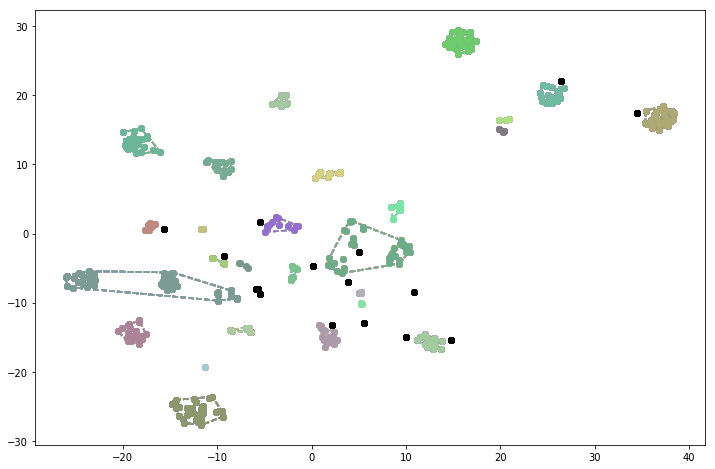

In [4]:
plt.figure(figsize=(12, 8))
for i, cluster in enumerate(clusters):
    cluster_points_index = np.where(clusters == cluster)[0]
    cluster_points = transformed[cluster_points_index]
    
    if cluster != -1 and cluster_points.shape[0] > 2:
        color = np.random.uniform(0.4, 0.9, size=(3,))
        hull = ConvexHull(cluster_points)
        hull_surface = hull.points[hull.vertices]
        hull_size = hull_surface.shape[0]
        
        plt.plot(hull_surface[:, 0], hull_surface[:, 1], "--", c=color)
        plt.plot(hull_surface[(-1, 0), 0], hull_surface[(-1, 0), 1], "--", c=color)
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], "o", c=color)
    else:
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], "o", c=(0, 0, 0))

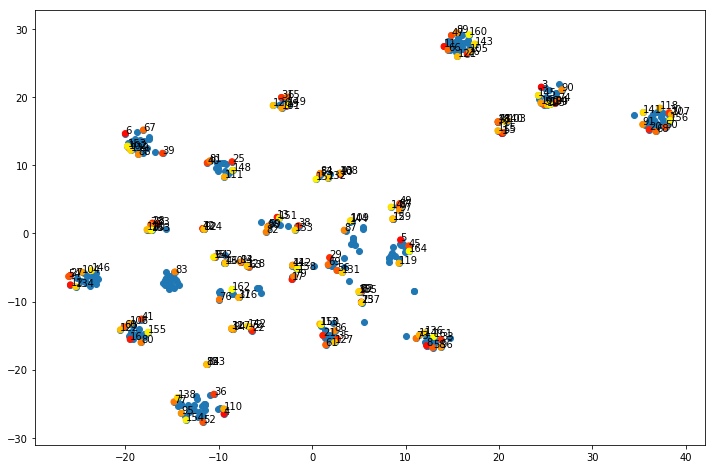

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(transformed[:, 0], transformed[:, 1])
points = transformed[indices]
plt.scatter(points[:, 0], points[:, 1], c=np.arange(points.shape[0]), 
            cmap=plt.get_cmap("autumn"))
for i, point in enumerate(points):
    plt.annotate(i, point)
display()

In [6]:
from image_store import ImageStore
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from functools import partial
import pandas as pd
import numpy as np
import json

config = json.load(open("../config.json"))
store = ImageStore.read(config["STORE_DIR"])

param_dict = {
    "min_samples": range(2, 10),
    "eps": list(map(partial(round, ndigits=4), 
                    np.arange(0.25, 0.775, 0.025)))
}

def rand_score(estimator, X, labels_true=None):
    labels_pred = estimator.fit_predict(X)
    return adjusted_rand_score(labels_true, labels_pred)

cv = [(slice(None), slice(None))]

mask = store.info["verified"].values
X, y = store.encs[mask, :], pd.Categorical(store.info.subject).codes
    
gs = GridSearchCV(estimator=DBSCAN(), param_grid=param_dict, 
                  scoring=partial(rand_score, labels_true=y),
                  cv=cv, n_jobs=-1)

gs.fit(X)

scoring_frame = pd.DataFrame(gs.cv_results_["params"])
scoring_frame["scores"] = gs.cv_results_["split0_train_score"]
display(scoring_frame.sample(10))

labels_pred, labels_true = gs.best_estimator_.fit_predict(X), y
order = labels_true.argsort()
labels_true, labels_pred = labels_true[order], labels_pred[order]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.DataFrame(np.stack((labels_pred, labels_true)).T, 
#                          columns=["labels_pred", "labels_true"]))
print("best_score:", gs.best_score_)
print("best estimator:", gs.best_estimator_)

/home/pushkar/anaconda3/envs/Intangles-DL/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,eps,min_samples,scores
88,0.525,2,0.036873
125,0.625,7,0.000000
114,0.600,4,0.000000
160,0.750,2,0.000000
55,0.400,9,0.515194
80,0.500,2,0.073590
115,0.600,5,0.000000
10,0.275,4,0.160938
65,0.450,3,0.238867
67,0.450,5,0.236467


best_score: 0.854799293987552
best estimator: DBSCAN(algorithm='auto', eps=0.375, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=None, p=None)


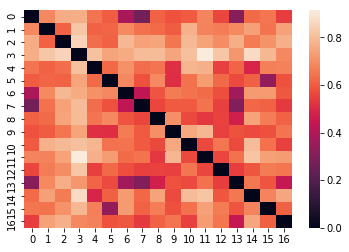

In [7]:
from scipy.spatial import distance_matrix
import seaborn as sns

def make_dist_mat(encs, pred, label):
    return distance_matrix(encs[pred == label], encs[pred == label])

sns.heatmap(make_dist_mat(store.encs, labels_pred, 33))